In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import IPython.display as ipd
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Flatten, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from spafe.features.pncc import pncc

In [2]:
df = pd.read_csv('./coconut-maturity-dataset-wav-luar-kotak.csv')
df

,full_path,file_name,class_name
0,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10a.wav,mature
1,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10b.wav,mature
2,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10c.wav,mature
3,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11a.wav,mature
4,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11b.wav,mature
...,...,...,...
175,./Sample-kelapa/data/cut_sample/tua/wav/tua8b.wav,tua8b.wav,overmature
176,./Sample-kelapa/data/cut_sample/tua/wav/tua8c.wav,tua8c.wav,overmature
177,./Sample-kelapa/data/cut_sample/tua/wav/tua9a.wav,tua9a.wav,overmature
178,./Sample-kelapa/data/cut_sample/tua/wav/tua9b.wav,tua9b.wav,overmature


In [3]:
def createWaveplot(data, sampleRate, maturity, color):
    plt.figure(figsize=(8,2))
    plt.title(f'Waveplot for {maturity} maturity', size = 15, pad = 20)
    librosa.display.waveshow(data, sr=sampleRate, alpha=0.5, color=color)
    plt.show()

def amplitude_envelope(signal, frame_size: int = 2048, hop_length: int = 512):
    """Calculate the amplitude envelope of a signal with a given frame size nad hop length."""
    amplitude_envelope = []

    # calculate amplitude envelope for each frame
    for i in range(0, len(signal), hop_length):
        amplitude_envelope_current_frame = max(signal[i:i+frame_size])
        amplitude_envelope.append(amplitude_envelope_current_frame)

    return np.reshape(np.array(amplitude_envelope), (1, len(amplitude_envelope)))

In [4]:
mfccs = []
mfcc_vectors = []
mean = []
variance = []

for filename in df['full_path'].values:
    wavSig, sampRate = librosa.load(filename, sr = 44100)
    mean_result = np.mean(wavSig)
    variance_result = np.var(wavSig)
    mfcc_result = librosa.feature.mfcc(y=wavSig, sr=sampRate)
    mean.append(mean_result)
    variance.append(variance_result)
    mfccs.append(mfcc_result.T)
    mfcc_vectors.append(mfcc_result.T.shape)

In [7]:
print(mfcc_result)
print(mfcc_result.shape)
print('')
print(mfcc_result.T)
print(mfcc_result.T.shape)

[[-620.36444 -620.36444 -620.36444 ... -620.36444 -620.36444 -620.36444]
 [   0.         0.         0.      ...    0.         0.         0.     ]
 [   0.         0.         0.      ...    0.         0.         0.     ]
 ...
 [   0.         0.         0.      ...    0.         0.         0.     ]
 [   0.         0.         0.      ...    0.         0.         0.     ]
 [   0.         0.         0.      ...    0.         0.         0.     ]]
(20, 87)

[[-620.36444    0.         0.      ...    0.         0.         0.     ]
 [-620.36444    0.         0.      ...    0.         0.         0.     ]
 [-620.36444    0.         0.      ...    0.         0.         0.     ]
 ...
 [-620.36444    0.         0.      ...    0.         0.         0.     ]
 [-620.36444    0.         0.      ...    0.         0.         0.     ]
 [-620.36444    0.         0.      ...    0.         0.         0.     ]]
(87, 20)


In [5]:
df['mean'] = mean
df['variance'] = variance
df['MFCC-feature'] = mfccs
df['MFCC-feature-size'] = mfcc_vectors
df

,full_path,file_name,class_name,mean,variance,MFCC-feature,MFCC-feature-size
0,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10a.wav,mature,0.000069,0.000408,"[[-701.946, 0.08432183, 0.0843023, 0.08427103,...","(87, 20)"
1,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10b.wav,mature,0.000026,0.001051,"[[-630.9958, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(87, 20)"
2,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10c.wav,mature,-0.000126,0.001053,"[[-635.13324, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","(87, 20)"
3,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11a.wav,mature,-0.000061,0.000586,"[[-675.0787, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(87, 20)"
4,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11b.wav,mature,-0.000075,0.000980,"[[-641.4125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(87, 20)"
...,...,...,...,...,...,...,...
175,./Sample-kelapa/data/cut_sample/tua/wav/tua8b.wav,tua8b.wav,overmature,-0.000132,0.000650,"[[-686.12384, 0.106780596, 0.10675647, 0.10671...","(87, 20)"
176,./Sample-kelapa/data/cut_sample/tua/wav/tua8c.wav,tua8c.wav,overmature,-0.000131,0.000500,"[[-681.6004, 0.26165962, 0.26154333, 0.2613471...","(87, 20)"
177,./Sample-kelapa/data/cut_sample/tua/wav/tua9a.wav,tua9a.wav,overmature,-0.000091,0.000763,"[[-663.4802, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(87, 20)"
178,./Sample-kelapa/data/cut_sample/tua/wav/tua9b.wav,tua9b.wav,overmature,0.000019,0.000815,"[[-643.6695, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(87, 20)"


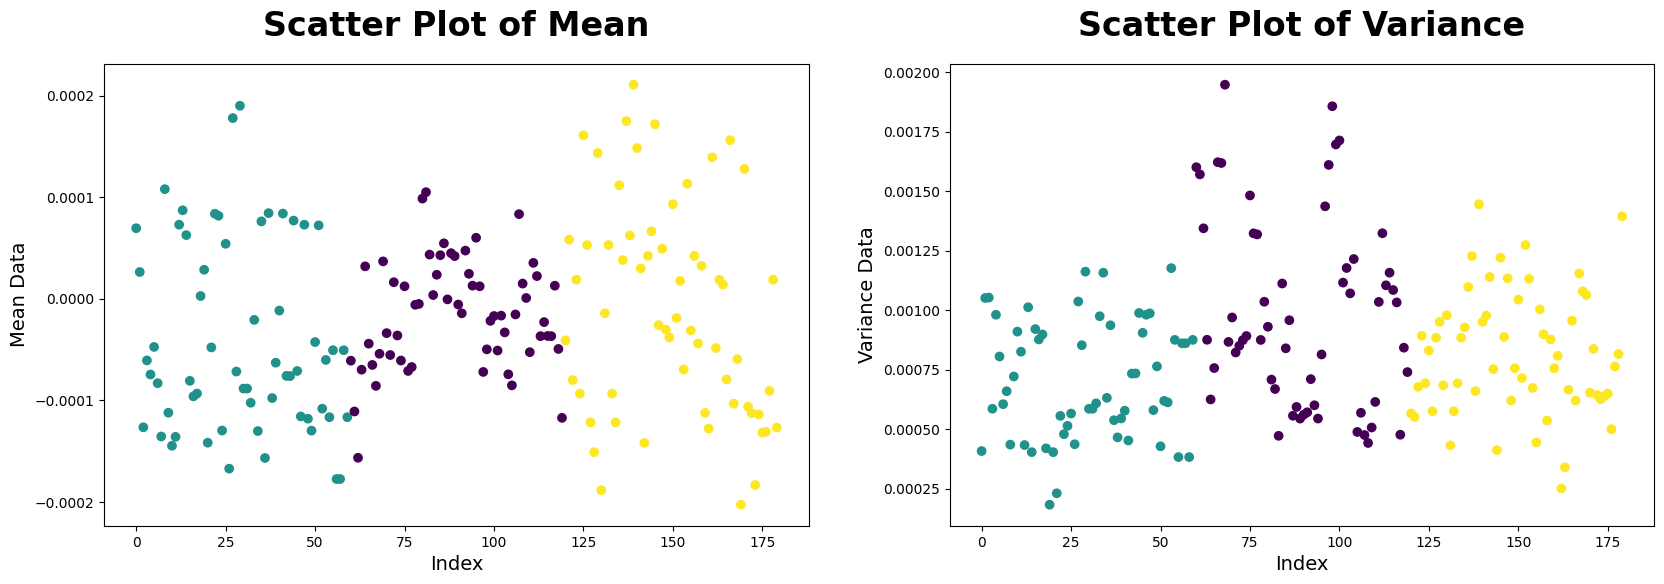

In [6]:
mean_data = df['mean'].values
var_data = df['variance'].values
indices = np.arange(len(df['class_name'].values))
label_encoder = LabelEncoder()
label_encoder.fit(df['class_name'].values)
colors = label_encoder.transform(df['class_name'].values)

plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.scatter(indices, mean_data, c=colors)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Mean Data', fontsize=14)
plt.title('Scatter Plot of Mean', fontsize=24, pad=20, fontweight='bold')
plt.subplot(122)
plt.scatter(indices, var_data, c=colors)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Variance Data', fontsize=14)
plt.title('Scatter Plot of Variance', fontsize=24, pad=20, fontweight='bold')
plt.show()

In [7]:
mfcc_feature = np.stack(df['MFCC-feature'].values)
X = mfcc_feature.reshape(180, -1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

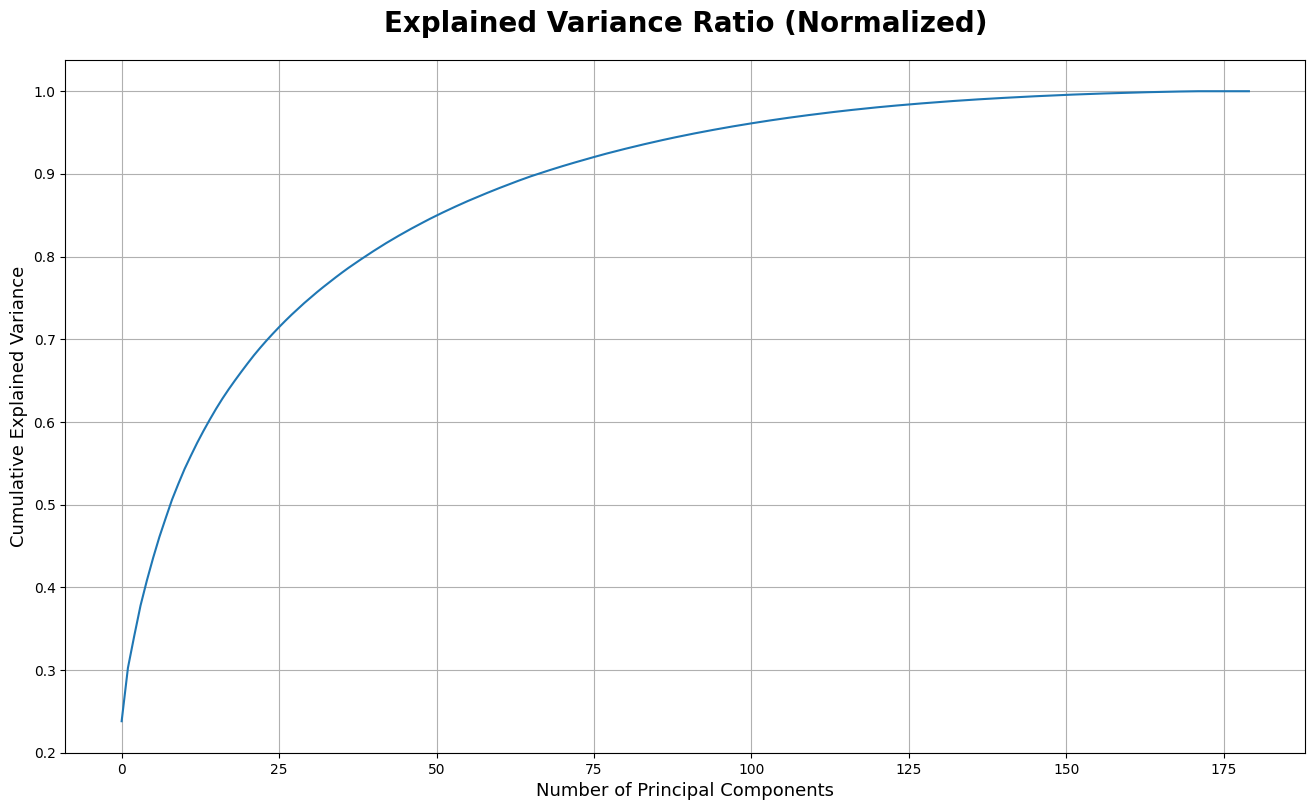

In [8]:
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

plt.subplots(figsize = (16, 9))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components', fontsize=13)
plt.ylabel('Cumulative Explained Variance', fontsize=13)
plt.title('Explained Variance Ratio (Normalized)', fontsize=20, pad=20, fontweight='bold')
plt.grid(which='both')
plt.show()

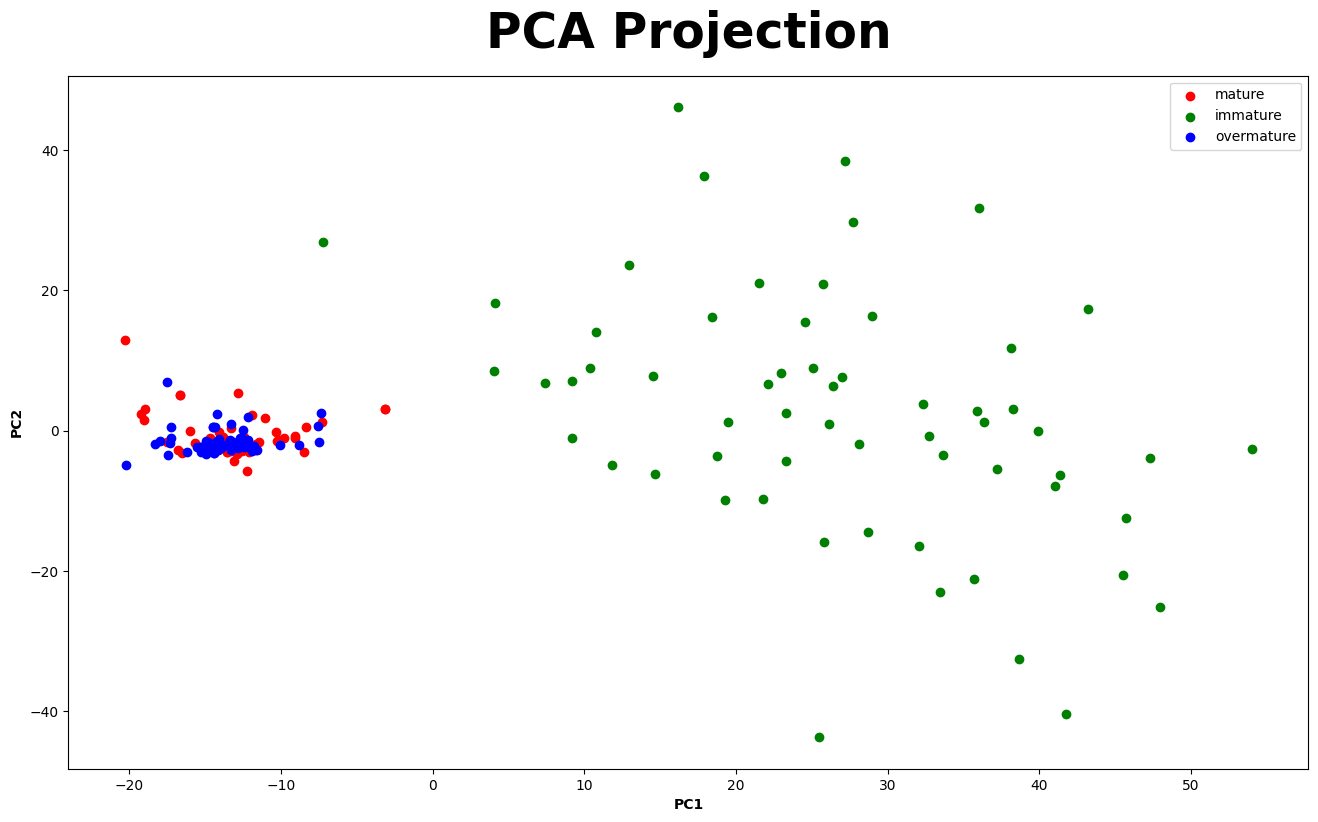

In [9]:
labels = df['class_name'].values.tolist()
label_colors = {'mature': 'red', 'immature': 'green', 'overmature': 'blue'}

x = pca_result[:, 0]
y = pca_result[:, 1]

unique_labels = set(labels)

fig, ax = plt.subplots(figsize=(16, 9))
for label in unique_labels:
    indices = np.where(np.array(labels) == label)
    ax.scatter(x[indices], y[indices], c=label_colors[label], label=label)

plt.title('PCA Projection', fontsize=35, fontweight='bold', pad=20)
plt.xlabel('PC1', fontweight='bold')
plt.ylabel('PC2', fontweight='bold')
ax.legend()
plt.show()

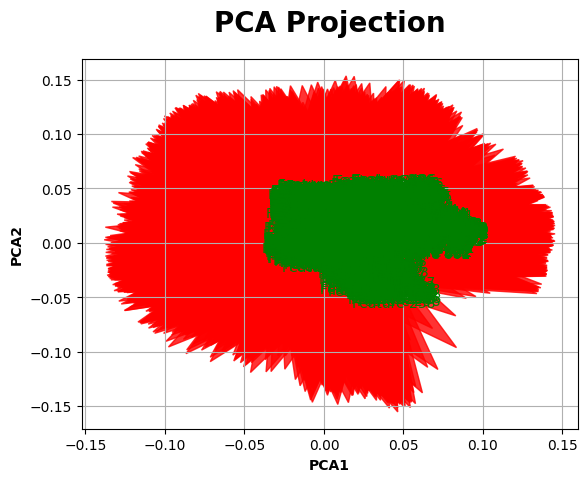

In [10]:
fig, ax = plt.subplots()
loadings = pca.components_.T
for i, feature_vector in enumerate(loadings):
    ax.arrow(0, 0, feature_vector[0], feature_vector[1], color='r', head_width=.05, head_length=.1, alpha=.8)
    ax.text(feature_vector[0], feature_vector[1], f'Feature {i+1}', color='g')
ax.set_title('PCA Projection', fontsize=20, pad=20, fontweight='bold', )
ax.set_xlabel('PCA1', fontweight='bold')
ax.set_ylabel('PCA2', fontweight='bold')
plt.grid(which='both')
plt.show()

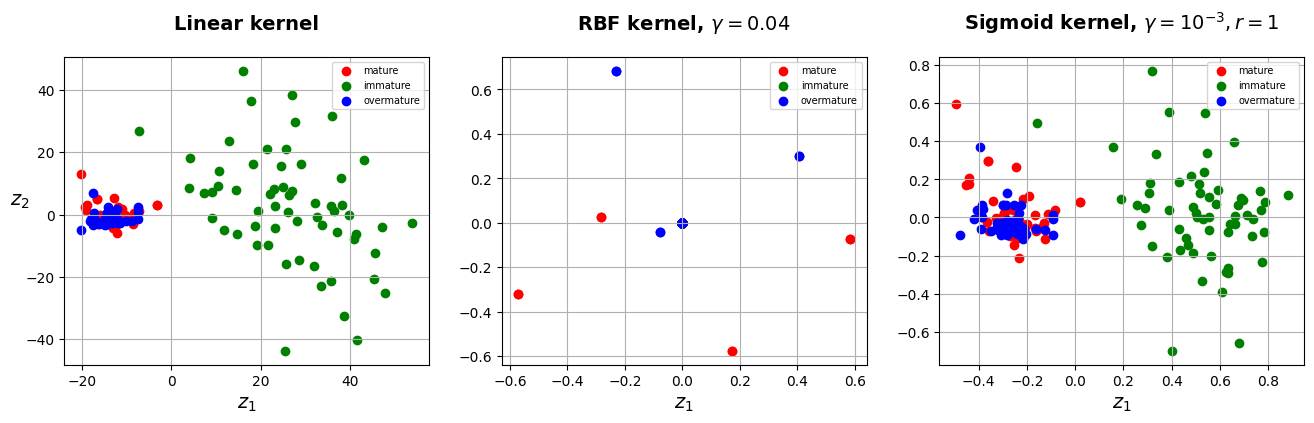

In [11]:
lin_pca = KernelPCA(n_components=75, kernel="linear")
rbf_pca = KernelPCA(n_components=75, kernel="rbf", gamma=0.0433)
sig_pca = KernelPCA(n_components=75, kernel="sigmoid", gamma=0.001)

unique_labels = set(labels)
label_colors = {'mature': 'red', 'immature': 'green', 'overmature': 'blue'}

plt.figure(figsize=(16, 4))
for subplot, pca, title in((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    reduced = pca.fit_transform(X_scaled)

    x = reduced[:, 0]
    y = reduced[:, 1]

    plt.subplot(subplot)
    for label in unique_labels:
        indices = np.where(np.array(labels) == label)
        plt.scatter(x[indices], y[indices], c=label_colors[label], label=label)

    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.xlabel("$z_1$", fontsize=14)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=14, rotation=0)
    plt.legend(fontsize=7)
    plt.grid()
plt.show()

In [12]:
print(f'mfcc_feature shape\t\t\t: {mfcc_feature.shape}')
reshaped_feature = mfcc_feature.reshape(180, -1)
print(f'reshaped_feature shape\t\t\t: {reshaped_feature.shape}')
scaler = StandardScaler()
scaler.fit(reshaped_feature)
normalized_feature = scaler.transform(reshaped_feature)
print(f'normalized_feature shape\t\t: {normalized_feature.shape}')
normalized_feature = normalized_feature.reshape(180, 87, 20)
print(f'normalized_feature shape after reshape\t: {normalized_feature.shape}')

mfcc_feature shape			: (180, 87, 20)
reshaped_feature shape			: (180, 1740)
normalized_feature shape		: (180, 1740)
normalized_feature shape after reshape	: (180, 87, 20)


In [13]:
# Create an instance of OneHotEncoder
labels = df['class_name'].values
one_hot_encoder = OneHotEncoder()

# Fit and transform the labels
encoded_labels = one_hot_encoder.fit_transform(labels.reshape(-1, 1)).toarray()
encoded_labels.shape

(180, 3)

In [14]:
print(f'ukuran data fitur : {encoded_labels.shape}')
print(f'ukuran data label : {normalized_feature.shape}')

ukuran data fitur : (180, 3)
ukuran data label : (180, 87, 20)


In [16]:
x_train, x_test, y_train, y_test = train_test_split(normalized_feature, encoded_labels, train_size=0.8, random_state=4, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((144, 87, 20), (144, 3), (36, 87, 20), (36, 3))

In [40]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
y_train_encoded.shape, y_test_encoded.shape

((144, 3, 2), (36, 3, 2))

In [16]:
x_train = np.expand_dims(x_train,axis=2)
x_test = np.expand_dims(x_test,axis=2)
print(f"Ukuran data train\t: {x_train.shape}")
print(f"Ukuran data test\t: {x_test.shape}")

Ukuran data train	: (144, 1740, 1)
Ukuran data test	: (36, 1740, 1)


In [17]:
log_dir = os.path.join('logs_mfcc_lstm_tweaked_50')
tb_callback = TensorBoard(log_dir=log_dir)
checkpoint_filepath = 'checkpoint_mfcc_lstm_tweaked_50/model_checkpoints_{epoch:02d}.h5'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_best_only=False,
                                      save_weights_only=False,
                                      save_freq=5)
rlrp = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, verbose=0, patience=1, min_lr=0.001)
terminate = TerminateOnNaN()

In [49]:
x_train.shape[1], x_train.shape[2]

(87, 20)

In [18]:
model = Sequential()
model.add(LSTM(units=64,
               dropout=0.05,
               recurrent_dropout=0.20,
               return_sequences=True,
               activation='relu',
               input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(units=128,
               dropout=0.05,
               recurrent_dropout=0.20,
               return_sequences=True,
               activation='relu'))
model.add(LSTM(units=64,
               dropout=0.05,
               recurrent_dropout=0.20,
               return_sequences=False,
               activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Flatten())
model.add(Dense(units=3, activation='softmax'))
model.compile(optimizer = Adam(1e-4) , loss = 'categorical_crossentropy' , metrics = ['categorical_accuracy', 'accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 87, 64)            21760     
                                                                 
 lstm_1 (LSTM)               (None, 87, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 32)                2

In [19]:
LSTM_model = model.fit(x_train, y_train, batch_size=12, epochs=50, validation_data=(x_test, y_test), callbacks=[terminate, tb_callback, checkpoint_callback])

Epoch 1/50
12/12 [==============================] - 12s 374ms/step - loss: 1.0957 - categorical_accuracy: 0.3056 - accuracy: 0.3056 - val_loss: 1.0867 - val_categorical_accuracy: 0.4444 - val_accuracy: 0.4444
Epoch 2/50
12/12 [==============================] - 4s 360ms/step - loss: 1.0824 - categorical_accuracy: 0.5069 - accuracy: 0.5069 - val_loss: 1.0708 - val_categorical_accuracy: 0.5000 - val_accuracy: 0.5000
Epoch 3/50
12/12 [==============================] - 5s 412ms/step - loss: 1.0621 - categorical_accuracy: 0.6042 - accuracy: 0.6042 - val_loss: 1.0403 - val_categorical_accuracy: 0.5000 - val_accuracy: 0.5000
Epoch 4/50
12/12 [==============================] - 5s 398ms/step - loss: 1.0183 - categorical_accuracy: 0.6319 - accuracy: 0.6319 - val_loss: 0.9687 - val_categorical_accuracy: 0.4722 - val_accuracy: 0.4722
Epoch 5/50
12/12 [==============================] - 5s 382ms/step - loss: 0.9504 - categorical_accuracy: 0.5833 - accuracy: 0.5833 - val_loss: 0.8519 - val_categorical

In [20]:
modelResults = model.evaluate(x_test, y_test)

2/2 [==============================] - 2s 45ms/step - loss: 0.6537 - categorical_accuracy: 0.5833 - accuracy: 0.5833


In [21]:
print(f"LOSS\t\t: {round(modelResults[0]*100,2)}%")
print(f"ACCURACY\t: {round(modelResults[1]*100,2)}%")

train_acc = LSTM_model.history['accuracy']
train_loss = LSTM_model.history['loss']
test_acc = LSTM_model.history['val_accuracy']
test_loss = LSTM_model.history['val_loss']

LOSS		: 65.37%
ACCURACY	: 58.33%


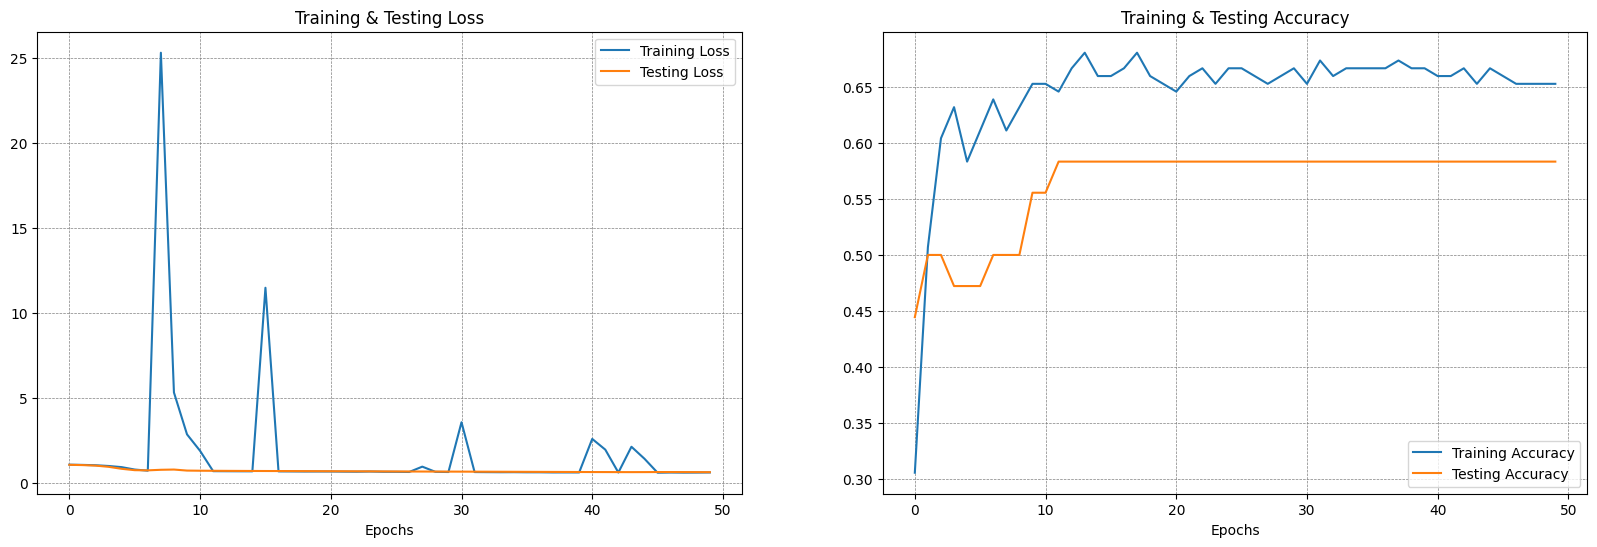

In [22]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].grid(which='both', linestyle='--', linewidth=0.5, color='gray')

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].grid(which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

In [23]:
pred_test = model.predict(x_test)
y_pred = one_hot_encoder.inverse_transform(pred_test)
y_test = one_hot_encoder.inverse_transform(y_test)
df_predict = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_predict['Predicted Labels'] = y_pred.flatten()
df_predict['Actual Labels'] = y_test.flatten()
df_predict.head(10)

2/2 [==============================] - 1s 26ms/step


,Predicted Labels,Actual Labels
0,immature,overmature
1,immature,immature
2,immature,immature
3,immature,immature
4,immature,immature
5,immature,immature
6,mature,overmature
7,mature,mature
8,mature,mature
9,mature,mature


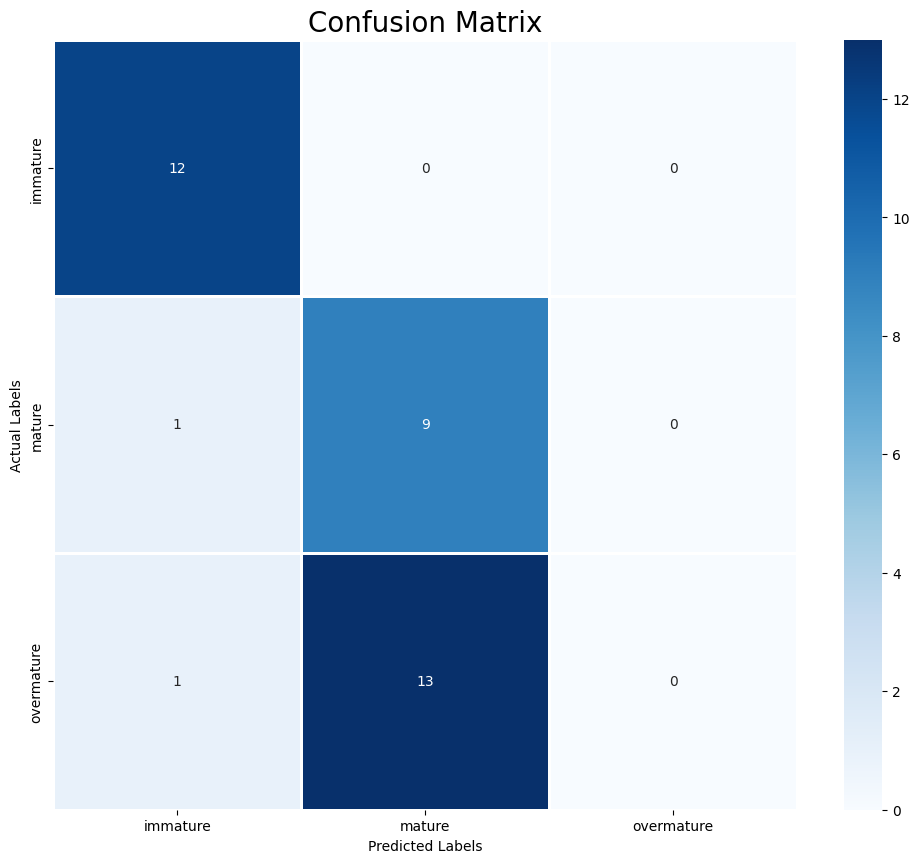

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in one_hot_encoder.categories_] , columns = [i for i in one_hot_encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=10)
plt.ylabel('Actual Labels', size=10)
plt.show()

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    immature       0.86      1.00      0.92        12
      mature       0.41      0.90      0.56        10
  overmature       0.00      0.00      0.00        14

    accuracy                           0.58        36
   macro avg       0.42      0.63      0.50        36
weighted avg       0.40      0.58      0.46        36



d:\Cool Yeah\Semester 118\coconut-maturity-classification\envSkripsi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Cool Yeah\Semester 118\coconut-maturity-classification\envSkripsi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Cool Yeah\Semester 118\coconut-maturity-classification\envSkripsi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

In [26]:
model.save('3_layer_LSTM_model_tweaked')

INFO:tensorflow:Assets written to: 3_layer_LSTM_model_tweaked\assets


INFO:tensorflow:Assets written to: 3_layer_LSTM_model_tweaked\assets
